In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)


In [4]:
"""This is a simulated environment.
  In reality for model-free tasks, we would interact with a real environment
"""
class Environment:
 
    def __init__(self, probs):
       # Success probabilities for each arm.
       # In practice, we don't know these values. We want to find them.
        self.probs = probs

    def step(self, action):
        # Pull arm and get stochastic reward (1 for success, 0 for failure)
        return 1 if (np.random.random()  < self.probs[action]) else 0


In [9]:
class Agent:

    def __init__(self, nActions, eps):
        self.nActions = nActions # Number of actions
        self.eps = eps # probability of exploration vs exploitation.
        self.n = np.zeros(nActions, dtype=int) # action counts n(a)
        self.Q = np.zeros(nActions, dtype=float) # value Q(a)

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        self.n[action] += 1
        # A computation efficient strategy to store the value function.
        # This is the average cumilative reward per action
        self.Q[action] += (1.0/self.n[action]) * (reward - self.Q[action])

    def get_action(self):
        # Epsilon-greedy policy
        if np.random.random() < self.eps: # explore
            return np.random.randint(self.nActions)
        else: # exploit
            return np.random.choice(np.flatnonzero(self.Q == self.Q.max()))


In [10]:
def experiment(probs, N_episodes):
    """Start multi-armed bandit simulation"""
    env = Environment(probs) # initialize arm probabilities
    agent = Agent(len(env.probs), eps)  # initialize agent
    actions, rewards = [], []
    for episode in range(N_episodes):
        action = agent.get_action() # sample policy # integer correcponding to the arm taken.
        reward = env.step(action) # take step + get reward # integer 0/1
        agent.update_Q(action, reward) # update Q
        actions.append(action) # list of ints
        rewards.append(reward) # list of ints
    return np.array(actions), np.array(rewards) # 500 x 1, 500 x 1


In [11]:
# Settings
probs = [0.10, 0.50, 0.60, 0.80, 0.10,
         0.25, 0.60, 0.45, 0.75, 0.65] # bandit arm probabilities of success
# This is the ground truth we don't know initially.
N_steps = 500 # number of steps (per episode)
N_experiments = 10_000 # number of experiments to perform
eps = 0.1 # probability of random exploration (fraction)
save_fig = True # save file in same directory
output_dir = os.path.join(os.getcwd(), "output")


In [12]:
# Run multi-armed bandit experiments
print("Running multi-armed bandits with nActions = {}, eps = {}".format(len(probs), eps))
R = np.zeros((N_steps,))  # reward history sum. 500 x 1
A = np.zeros((N_steps, len(probs)))  # action history sum 500 x 10
for i in range(N_experiments):
    actions, rewards = experiment(probs, N_steps)  # perform experiment. actions = 500x1, rewards = 500x1
    if (i + 1) % (N_experiments / 100) == 0:
        print("[Experiment {}/{}] ".format(i + 1, N_experiments) +
              "n_steps = {}, ".format(N_steps) +
              "reward_avg = {}".format(np.sum(rewards) / len(rewards)))
    R += rewards # Adding rewards for every time step across all experiments: 500x1
    for j, a in enumerate(actions):
        # step_index x num_actions = 500 x 10.
        # Each cell holds number of actions a in time step j across all experiments
        A[j][a] += 1


Running multi-armed bandits with nActions = 10, eps = 0.1
[Experiment 100/10000] n_steps = 500, reward_avg = 0.716
[Experiment 200/10000] n_steps = 500, reward_avg = 0.772
[Experiment 300/10000] n_steps = 500, reward_avg = 0.718
[Experiment 400/10000] n_steps = 500, reward_avg = 0.734
[Experiment 500/10000] n_steps = 500, reward_avg = 0.648
[Experiment 600/10000] n_steps = 500, reward_avg = 0.674
[Experiment 700/10000] n_steps = 500, reward_avg = 0.668
[Experiment 800/10000] n_steps = 500, reward_avg = 0.668
[Experiment 900/10000] n_steps = 500, reward_avg = 0.738
[Experiment 1000/10000] n_steps = 500, reward_avg = 0.704
[Experiment 1100/10000] n_steps = 500, reward_avg = 0.738
[Experiment 1200/10000] n_steps = 500, reward_avg = 0.632
[Experiment 1300/10000] n_steps = 500, reward_avg = 0.75
[Experiment 1400/10000] n_steps = 500, reward_avg = 0.662
[Experiment 1500/10000] n_steps = 500, reward_avg = 0.752
[Experiment 1600/10000] n_steps = 500, reward_avg = 0.744
[Experiment 1700/10000] 

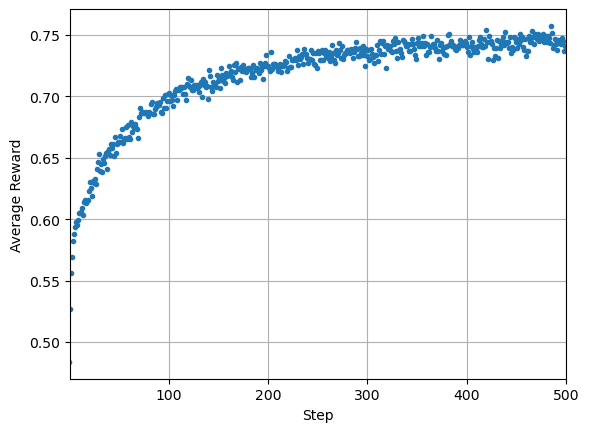

In [15]:
# Plot reward results

# 500 x 1 - each cell is average reward per timestep across all experiments.
# Ideally this increases on average over time as the agent learns. Check rewards.png.
R_avg =  R / float(N_experiments)
plt.plot(R_avg, ".")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.grid()
ax = plt.gca()
plt.xlim([1, N_steps])
if save_fig:
    if not os.path.exists(output_dir): os.mkdir(output_dir)
    plt.savefig(os.path.join(output_dir, "rewards.png"), bbox_inches="tight")
else:
    plt.show()
    
plt.show()    
plt.close()


C:\Users\INTuser\AppData\Local\Temp\ipykernel_20812\610485448.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


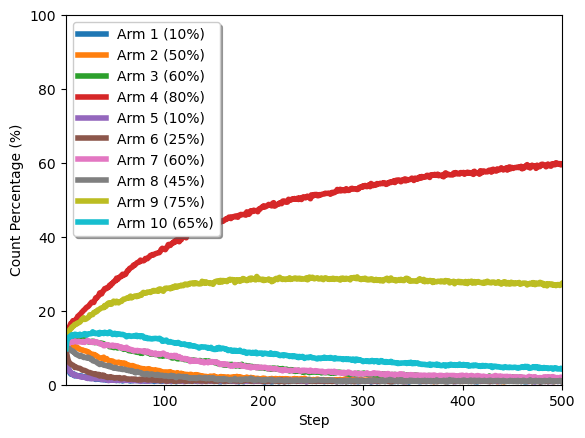

In [16]:
# Plot action results
for i in range(len(probs)):
    A_pct = 100 * A[:,i] / N_experiments # num_steps x 1 = 500 x 1
    # Each cell is number of times the action i was selected for time step j across all experiments /  number of experiments conducted
    steps = list(np.array(range(len(A_pct)))+1) # [0, 1, 2, 3 , 4, ..., 500]
    # Plotting line chart for just 1 action i at a time.
    plt.plot(steps, A_pct, "-",
             linewidth=4,
             label="Arm {} ({:.0f}%)".format(i+1, 100*probs[i])) # Incrementing Arm + 1 as they start with 0 index
    # We should ideally see as timesteps go on, the slot with the largest probability of success is chosen the most.
    # check actions.png
plt.xlabel("Step")
plt.ylabel("Count Percentage (%)")
leg = plt.legend(loc='upper left', shadow=True)
plt.xlim([1, N_steps])
plt.ylim([0, 100])
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
if save_fig:
    if not os.path.exists(output_dir): os.mkdir(output_dir)
    plt.savefig(os.path.join(output_dir, "actions.png"), bbox_inches="tight")
else:
    plt.show()
    
plt.show()    
plt.close()